# Project MDA (Heatwave data)

## Importing packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import sklearn as sk
import tensorflow as tf


from statsmodels.tsa.seasonal import seasonal_decompose
import math
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten, Dropout
from tensorflow import keras
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Importing time series input data

In [2]:
# Constants
COUNTRY_MAPPINGS = {'Belgium':'BE_temperature','Netherlands':'NL_temperature'} # to be continued...
MONTH_TO_DAY_MAPPINGS = {'1.0':31,'2.0':28,'3.0':31,'4.0':30,'5.0':31,'6.0':30,'7.0':31,'8.0':31,'9.0':30,'10.0':31,'11.0':30,'12.O':31}

def get_avg_temp(year, month, day, duration, country): # ('2003','08','15',4,'Belgium')
    """
    Given a period and country in which a heatwave occurs, return the avg temperature of this period.
    """
    begin_date = str(year) + '-' + str(month) + '-' + str(day) + 'T00:00:00Z'
    print(begin_date)
    data = pd.read_csv('weather_data.csv')
    country = COUNTRY_MAPPINGS[country]
    df = data[['utc_timestamp',country]]
    #df['utc_timestamp'] = df['utc_timestamp'].astype('string')
    begin_index = df.index[df['utc_timestamp'] == begin_date].tolist()[0]
    end_index = begin_index + (duration * 24)
    heat_wave_temps = df.iloc[begin_index:end_index]
    avg_temp = round(heat_wave_temps[country].sum()/len(heat_wave_temps.index),2)
    return avg_temp

def get_month_to_day(months):
    """
    Returns amount of days in a certain month.
    """
    return [MONTH_TO_DAY_MAPPINGS[str(m)] for m in months]

def plot(df_out,column_name):
    """
    Plot a certain column of a certain df.
    """
    x = df_out['Year'].to_numpy()
    y = df_out[column_name].to_numpy()
    plt.plot(x, y)
    plt.show()

## Get input time series

In [3]:
country = 'Netherlands'
product = 'Agriculture'

def get_input_time_series(country):
    """
    Returns the 3 time series of a certain country. Save as pickle file to later use with other data.
    -----------------------------------------------------------------
    Time Series 1: Amount heatwaves (per year)
    Time Series 2: Average temperature during all heatwaves (per year)
    Time Series 3: Average temperature in general
    """

    # Read in the full dataset, and only keep the heatwave data of the given country.
    colslist = ['Year','Disaster Subtype','Country','Start Month','Start Day','End Month','End Day']
    df = pd.read_excel('disaster_data.xlsx',usecols=colslist)
    df = df[df['Disaster Subtype'] == 'Heat wave']
    df = df[df['Country'] == country]
    df = df[df['Year'] >= 1980] # we only have temperature data from 1980-2019!
    df = df[df['Year'] <= 2019]
    year_list = np.linspace(1980,2019,2020-1980)
    df_out = pd.DataFrame({"Year": year_list})
    df_merged = pd.merge(df_out, df, how='left', on='Year')

    #-------------- Time Series 1: Amount heatwaves (per year) --------------#
    amount_list = [len(df[df['Year'] == y].index) for y in year_list]
    df_out['amount_heatwaves'] = amount_list
    #plot(df_out, 'amount_heatwaves')

    #-------------- Time Series 2: Average temperature during all heatwaves (per year) --------------#

    # only begin- and end month and day given. So need to compute the exact duration of the heatwave which depends on the starting month.
    # Further, sometimes there's no start or end day given. If that's the case, take the avg temp of the month given.

    df = df.assign(month_difference=lambda row: row['End Month'] - row['Start Month'])
    df = df.assign(day_difference=lambda row: row['End Day'] - row['Start Day'])
    # TO DO: we only have temperature data from 1980 up until end of 2019 so we need to drop all our invalid heatwave data before computing temperatures
    # df = df(df['Year'] >= 1980)
    # df = df(df['Year'] <= 2015)
    df['duration'] = np.where(df['day_difference'] >= 0, df['day_difference'], 0)
    df['duration'] = np.where(df['day_difference'].isna(),get_month_to_day(df['Start Month']),df['duration']) # this can be still adjusted!
    df['duration'] = np.where(df['month_difference'] == 1, get_month_to_day(df['Start Month'])-df['Start Day'] + df['End Day'], df['duration'])
    df['duration'] = np.where(df['duration'].isna(), 30, df['duration']) # this can be still adjusted!
    df['start_day_for_duration'] = np.where(~df['Start Day'].isna(),df['Start Day'],1) # this can be still adjusted!

    # convert pd data to lists so we can perform the get_avg_temp function
    day_mapping = {1.0 :'01', 2.0 : '02', 3.0 : '03', 4.0 : '04', 5.0 : '05', 6.0 : '06', 7.0 : '07', 8.0 : '08', 9.0 : '09', 10.0 : '10', 11.0 : '11', 12.0 : '12', 13.0 : '13', 14.0 : '14', 15.0 : '15', 16.0 : '16', 17.0 : '17', 18.0 : '18', 19.0 : '19', 20.0 : '20', 21.0 : '21', 22.0 : '22', 23.0 : '23', 24.0 : '24', 25.0 : '25', 26.0 : '26', 27.0 : '27', 28.0 : '28', 29.0 : '29', 30.0 : '30', 31.0 : '31'}
    years_heatwave_list = [y for y in df['Year']]
    begin_month_list = [day_mapping[m] for m in df['Start Month']]
    begin_day_list = [day_mapping[day] for day in df['start_day_for_duration']]
    duration_list = [round(dur) for dur in df['duration']]
    avg_temps = [get_avg_temp(years_heatwave_list[i], begin_month_list[i], begin_day_list[i], duration_list[i], country) for i in range(len(years_heatwave_list))]

    # Compute avg temp --> list can be: [2003, 2006, 2015, 2018, 2019, 2019, 2019], take avg of the 2019 temps
    years_heatwave_array = np.array(years_heatwave_list)
    years_heatwave_array_unique = np.unique(years_heatwave_array)
    indices_array = [np.where(years_heatwave_array == year)[0] for year in years_heatwave_array_unique]
    df_out['avg_hw_temp'] = 0 # When there's no heatwave in a year, we put the avg temp = 0 for the time series
    for counter,indices in enumerate(indices_array):
        print(counter)
        temps = [avg_temps[ind] for ind in indices]
        avg_temp = round(sum(temps)/len(temps),2)
        print(avg_temp)
        df_out['avg_hw_temp'] = np.where(df_out['Year'] == years_heatwave_array_unique[counter],avg_temp,df_out['avg_hw_temp'])
    print(df_out.to_markdown())
    #plot(df_out,'avg_hw_temp')

    #-------------- Time Series 3: Average temperature in general --------------#
    avg_temps = [get_avg_temp(int(y), '01', '01', 365, country) for y in year_list]
    print(avg_temps)
    df_out['avg_temp'] = avg_temps
    print(df_out.to_markdown())
    #plot(df_out,'avg_temp')
    df_out.to_pickle(f"{country}.pkl")

    return df_out

df = get_input_time_series(country)

|    |   Year |   amount_heatwaves |   avg_hw_temp |
|---:|-------:|-------------------:|--------------:|
|  0 |   1980 |                  0 |             0 |
|  1 |   1981 |                  0 |             0 |
|  2 |   1982 |                  0 |             0 |
|  3 |   1983 |                  0 |             0 |
|  4 |   1984 |                  0 |             0 |
|  5 |   1985 |                  0 |             0 |
|  6 |   1986 |                  0 |             0 |
|  7 |   1987 |                  0 |             0 |
|  8 |   1988 |                  0 |             0 |
|  9 |   1989 |                  0 |             0 |
| 10 |   1990 |                  0 |             0 |
| 11 |   1991 |                  0 |             0 |
| 12 |   1992 |                  0 |             0 |
| 13 |   1993 |                  0 |             0 |
| 14 |   1994 |                  0 |             0 |
| 15 |   1995 |                  0 |             0 |
| 16 |   1996 |                  0 |          

## Merging HeatWave data with production index data

In [4]:
def get_production_index_time_series(country, item):
    df = pd.read_excel('World_prodvolumes.xls')

    all_countries = df['Area'].unique()
    all_items = df['Item'].unique()

    df = df[df['Area'] == country]
    df = df[df['Item'] == item]
    df = df[df['Year'] >= 1980]  # we only have temperature data from 1980-2019!
    df = df[df['Year'] <= 2019]
    df = df[['Year','Value']]
    df.fillna(df.mean(), inplace=True)

    print(all_countries)
    print(all_items)
    print(df.to_markdown())

    return df

    #get_production_index_time_series('Afghanistan','Agriculture')

def merge_time_series(country, item):
    """
    Read out a already computed pkl file of the 3 heat-related input time series and concatenate the product index time series to it.
    """
    df = pd.read_pickle(f"{country}.pkl")
    df_item = get_production_index_time_series(country, item)
    df_item = df_item.set_index(df.index) # indices have to be adjusted, otherwise NaN values!
    df['Value'] = df_item['Value']
    return df

## Importing DataFrame

In [5]:
df_total = merge_time_series(country,product)
df_total = df_total.drop('Year',axis=1) # not needed. Maybe later for plotting.
amount = len(df_total)
df_train = df_total[:math.floor(amount -5)]
df_test = df_total[math.floor(amount -5):]
y_true = np.array(df_test["Value"])

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium'
 'Belgium-Luxembourg' 'Belize' 'Benin' 'Bhutan'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Channel Islands' 'Chile' 'China, Hong Kong SAR'
 'China, Macao SAR' 'China, mainland' 'China, Taiwan Province of'
 'Colombia' 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' "C?te d'Ivoire"
 'Croatia' 'Cuba' 'Cyprus' 'Czechia' 'Czechoslovakia'
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Ethiopia PDR' 'Faroe Islands'
 'Fiji' 'Finland' 'France' 'French Guyana' 'F

## Preprocessing

### Scaling the data 

In [6]:
# scale training and test sets
sc1 = MinMaxScaler(feature_range=(0,1))
scaled_df_train = sc1.fit_transform(df_train)
scaled_df_test = sc1.fit_transform(df_test)


# now we have a numpy array and we tranform back to a dataframe with the scaled values
scaled_df_train1 = pd.DataFrame(scaled_df_train, columns = ['amount_heatwaves','avg_hw_temp','avg_temp', 'Value'])
scaled_df_test1 = pd.DataFrame(scaled_df_test, columns = ['amount_heatwaves','avg_hw_temp','avg_temp', 'Value'])

### Create X_train and y_train

In [7]:
X_train = scaled_df_train1.drop("Value", axis = 1) 
y_train = scaled_df_train1["Value"]

X_test = scaled_df_test1.drop("Value", axis = 1)
y_test = scaled_df_test1["Value"]

 ## MODEL 1 : Linear regression

In [8]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print('Mean squared error from linear regression: ', mse_lr)
print('Mean absolute error from linear regression: ', mae_lr)

Mean squared error from linear regression:  0.0738870047987177
Mean absolute error from linear regression:  0.2560676897027294


## Model 2 : Decision Tree

In [9]:
### Decision tree
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_tree)
mae_dt = mean_absolute_error(y_test, y_pred_tree)
print('Mean squared error using decision tree: ', mse_dt)
print('Mean absolute error using decision tree: ', mae_dt)

Mean squared error using decision tree:  0.03340323366369951
Mean absolute error using decision tree:  0.15511769741775758


## Model 3 : Random Forest

In [10]:
#Random forest.
#Increase number of trees and see the effect
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 50, random_state=30)
model.fit(X_train, y_train)

y_pred_RF = model.predict(X_test)

mse_RF = mean_squared_error(y_test, y_pred_RF)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
print('Mean squared error using Random Forest: ', mse_RF)
print('Mean absolute error Using Random Forest: ', mae_RF)

#Feature ranking...
feature_list = list(X_train.columns)
feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
print(feature_imp)

Mean squared error using Random Forest:  0.041281331688611304
Mean absolute error Using Random Forest:  0.18290870812677393
avg_temp            1.0
amount_heatwaves    0.0
avg_hw_temp         0.0
dtype: float64


## Model 4 : MLP

In [11]:
### Modelling

# Set random seed
tf.random.set_seed(42)

# Create a model using the Sequential API
model = tf.keras.Sequential([
  tf.keras.layers.Dense(128), # 128 units
  tf.keras.layers.Dense(64), # 64 units
  tf.keras.layers.Dense(1) # 1 unit (important for output layer)
])

# Compile the model
model.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["mae"])

# Fit the model
# model.fit(X, y, epochs=5) # this will break with TensorFlow 2.7.0+
history = model.fit(X_train, y_train, epochs=100, verbose = 0)

2022-05-25 16:38:48.035424: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [12]:
# Check the results of our model

mse_neural, mae_neural = model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)

1/1 [==============================] - 0s 65ms/step - loss: 0.2447 - mae: 0.2447
Mean squared error from neural net:  0.2446630299091339
Mean absolute error from neural net:  0.2446630299091339


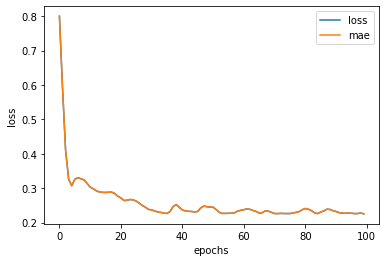

In [13]:
# Plot history (also known as the loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [14]:
# predict the next values of the test set
predictions_scaled = model.predict(X_test)
print(predictions_scaled)
zeros = np.zeros((5,3))
predictions_scaled = np.append(zeros,predictions_scaled,axis=1)
print(predictions_scaled)

# Re-transform the scaled data to the original format!
predictions = sc1.inverse_transform(predictions_scaled)[:,[3]]
print(predictions)

[[0.8800667 ]
 [0.8972591 ]
 [0.6909491 ]
 [0.37288734]
 [0.3041173 ]]
[[0.         0.         0.         0.88006669]
 [0.         0.         0.         0.89725912]
 [0.         0.         0.         0.69094908]
 [0.         0.         0.         0.37288734]
 [0.         0.         0.         0.30411729]]
[[101.86644684]
 [101.98163608]
 [100.59935885]
 [ 98.4683452 ]
 [ 98.00758586]]


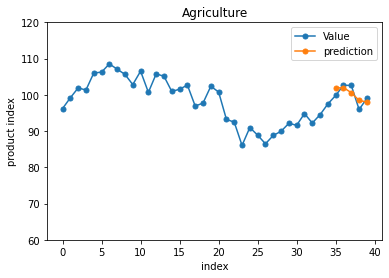

In [15]:
# plot the result
predictions_list = [i[0] for i in predictions]

predictions_for_plot = [None for i in range(len(df_train))] + predictions_list
df_total['prediction'] = predictions_for_plot
ax = df_total[['Value','prediction']].plot(ylim=(60,120), title=product, marker='.', markersize=10)
ax.set_xlabel("index")
ax.set_ylabel("product index")
plt.show()

## Model 4 : LSTM

### Split in training and test data

In [16]:
n = 5 # use 5 previous datapoints to predict the next one.
df_length = scaled_df_train.shape[0]
X_train = []
y_train = []
for i in range(n,df_length): # eg if df = [1,2,3,4,5,6,7,...]
    X_train.append(scaled_df_train[i-n:i]) # [1,2,3,4,5]
    y_train.append(scaled_df_train[i][-1]) # [6] = next one!
X_train = np.array(X_train)
y_train = np.array(y_train)
amount_time_series = X_train.shape[2]

### Make predictions

In [17]:
def predict(model):
    # -------------- Get ready for testing! --------------#

    # First get n latest values of the training set to predict the first value of the test set
    df = pd.concat([df_train.iloc[-n:], df_test])
    x_test_normal = df.values
    scaled_test = sc1.transform(x_test_normal)  # scale test data with the scaler of the training data!
    X_test = []
    for i in range(n, len(df)):
        X_test.append(scaled_test[i - n:i])
    X_test = np.array(X_test)

    # predict the next values of the test set
    predictions_scaled = model.predict(X_test)

    # Add zeros to yr predcitions, to fix the scaler error.
    zeros = np.zeros((n, amount_time_series - 1))
    predictions_scaled = np.append(zeros, predictions_scaled, axis=1)

    # Re-transform the scaled data to the original format!
    predictions = sc1.inverse_transform(predictions_scaled)[:, [3]]

    return predictions

### Make LSTM model

In [18]:
def make_model(amount_neurons,amount_dropout):

    model = Sequential()

    # add Layer 1 with dropout: deactivate 10% of neurons at random during training to avoid overfitting
    model.add(LSTM(amount_neurons, activation='relu', input_shape=(n, amount_time_series)))
    model.add(Dropout(amount_dropout))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse')

    #-------------- Fit the model on the training set --------------#
    model.fit(X_train,y_train,epochs=100)
    predictions = predict(model)
    mse = mean_squared_error(y_true, predictions.flatten())
    print(mse)

    return mse, model

## Gridsearch

In [19]:
def grid_search():
    grid_params = {'neurons':[10,20,40,50,100],'dropout_percentage':[0.05,0.1,0.2,0.5]}
    best_model = {'mse':100,'neurons':0,'dropout_percentage':0} # here we will save our best model in
    for i in grid_params['neurons']:
        for j in grid_params['dropout_percentage']:
            print(f"neurons: {i}, drop: {j}")
            mse,model = make_model(i,j)
            if mse < best_model['mse']:
                print('better model found! :)')
                best_model['mse'] =  mse
                best_model['neurons'] = i
                best_model['dropout_percentage'] = j
                model.save('best_model')
    print(best_model)

    best_model = keras.models.load_model('best_model')
    return best_model # Best model found includes 20 neurons and a dropout equal to 0.5

## Plotting results of best model

neurons: 10, drop: 0.05
Epoch 1/100
1/1 [==============================] - 1s 504ms/step - loss: 0.3971
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3773
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3746
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.3685
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3525
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3501
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3406
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3450
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3246
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.3339
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3155
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3120
Epoch 13/100
1/1 [=================

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2022-05-25 16:38:50.060771: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_model/assets


neurons: 10, drop: 0.1
Epoch 1/100
1/1 [==============================] - 0s 392ms/step - loss: 0.3246
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3258
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3238
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3160
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3136
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3225
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2994
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2891
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2906
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2793
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2890
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2714
Epoch 13/100
1/1 [==================

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


neurons: 10, drop: 0.2
Epoch 1/100
1/1 [==============================] - 0s 314ms/step - loss: 0.3829
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3673
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3755
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3689
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3522
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3523
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2985
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3091
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3323
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3334
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2829
Epoch 13/100
1/1 [==================

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 319ms/step - loss: 0.4344
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4272
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.4049
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4087
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4228
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4034
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4018
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.4044
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4075
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3989
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3712
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3835
Epoch 13/100
1/1 [==============================] - 0s 2ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


10.771317873076594
better model found! :)
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


neurons: 20, drop: 0.05
Epoch 1/100
1/1 [==============================] - 0s 305ms/step - loss: 0.4921
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4877
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.4846
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4814
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4788
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4683
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.4552
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4392
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4373
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4361
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4229
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4070
Epoch 13/100
1/1 [=================

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


15.351804507763433
neurons: 20, drop: 0.1
Epoch 1/100
1/1 [==============================] - 0s 311ms/step - loss: 0.3366
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3623
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3439
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3260
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3189
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3341
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2943
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3134
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2917
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2756
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2795
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2839
Epoch 13/100
1/1 

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 314ms/step - loss: 0.2432
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2605
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2641
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2363
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2321
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2151
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1989
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2168
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1871
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1593
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1599
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1652
Epoch 13/100
1/1 [==============================] - 0s 2ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 315ms/step - loss: 0.2724
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2544
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2422
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2450
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2122
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2081
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2279
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2107
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2361
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2070
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1788
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1935
Epoch 13/100
1/1 [==============================] - 0s 2ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 318ms/step - loss: 0.3317
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3258
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3211
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3117
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3022
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2967
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2875
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2803
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2714
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2622
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2569
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2470
Epoch 13/100
1/1 [==============================] - 0s 1ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 303ms/step - loss: 0.2551
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2384
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2362
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2284
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2156
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2153
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2002
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1956
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1857
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1715
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1693
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1581
Epoch 13/100
1/1 [==============================] - 0s 2ms/

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 313ms/step - loss: 0.4463
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.4432
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.4135
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3913
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3835
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3718
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3383
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3328
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3304
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3058
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2949
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2796
Epoch 13/100
1/1 [==============================] - 0s 2ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 317ms/step - loss: 0.3592
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3379
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3322
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3176
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3154
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2987
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2850
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3010
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2976
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2640
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2712
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2890
Epoch 13/100
1/1 [==============================] - 0s 2ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 317ms/step - loss: 0.5672
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.5338
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.5265
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5028
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4869
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4683
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.4473
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.4355
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4144
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4001
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3835
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3711
Epoch 13/100
1/1 [==============================] - 0s 3ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 314ms/step - loss: 0.2525
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2394
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2232
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2105
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2003
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1879
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1715
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1572
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1580
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1376
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1388
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1122
Epoch 13/100
1/1 [==============================] - 0s 2ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


neurons: 50, drop: 0.2
Epoch 1/100
1/1 [==============================] - 0s 307ms/step - loss: 0.3865
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3812
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3770
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3523
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3358
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3317
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3165
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3145
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2879
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2830
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2727
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2590
Epoch 13/100
1/1 [==================

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 316ms/step - loss: 0.2339
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2146
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2149
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2246
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2158
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2054
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1775
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1748
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1612
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1547
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1726
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1511
Epoch 13/100
1/1 [==============================] - 0s 2ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 320ms/step - loss: 0.4258
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.4069
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3864
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3730
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.3515
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3340
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.3156
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2980
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2898
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2690
Epoch 11/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2519
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2378
Epoch 13/100
1/1 [==============================] - 0s 3ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 414ms/step - loss: 0.2904
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2714
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2526
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2382
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2227
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2026
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1871
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1757
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1557
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1396
Epoch 11/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1321
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1146
Epoch 13/100
1/1 [==============================] - 0s 2ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 318ms/step - loss: 0.4293
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3930
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3768
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3565
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3383
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3113
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2947
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2730
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2436
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.2313
Epoch 11/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2177
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2011
Epoch 13/100
1/1 [==============================] - 0s 3ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 315ms/step - loss: 0.4084
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.4187
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3826
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3526
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3284
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.3331
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3184
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2798
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2799
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2648
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2306
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2280
Epoch 13/100
1/1 [==============================] - 0s 2ms/step - loss:

/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/pjcnudde/miniforge3/envs/MDA/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


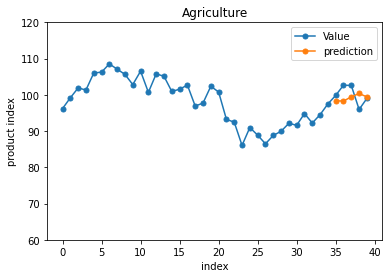

In [20]:
def plot(model):
    # plot the result

    predictions = predict(model)
    predictions_list = [i[0] for i in predictions]

    predictions_for_plot = [None for i in range(len(df_train))] + predictions_list
    df_total['prediction'] = predictions_for_plot
    ax = df_total[['Value','prediction']].plot(ylim=(60,120), title=product, marker='.', markersize=10)
    ax.set_xlabel("index")
    ax.set_ylabel("product index")
    plt.show()

best_model = grid_search()
plot(best_model)